In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as utils

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE
from src.vae_dense import DenseVAE
from src.vae_conv import ConvVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

2023-12-20 15:48:06,170 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



# Define Hyperparams

In [3]:
# HYPERPARAMS
N_EPOCHS: int = 256
N_BATCHES: int = 4
VAL_SPLIT: float = 0.2

# Size of the latent dimension
LATENT_DIM: int = 5

# Settings to save model and history / comparison plots
SAVE_MODEL: bool = False     # If set to true, model will be saved under ../models/ dir
MODEL_ID: str = utils.get_model_id(N_EPOCHS, N_BATCHES, VAL_SPLIT, LATENT_DIM)

# Load Data

In [37]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-20 15:57:36,880 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-20 15:57:51,502 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [38]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", partition_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-20 15:57:51,744 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-20 15:57:51,872 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-20 15:57:51,876 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.13s) ...


(430, 250, 7)


# Modelling

In [6]:
#vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae = DenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
#vae = ConvVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)

vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

2023-12-20 15:48:22,899 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2023-12-20 15:48:23,216 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-20 15:48:23,265 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\engine\base_layer_utils.py:189: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [7]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 1750)                 0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  448256    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                            

In [8]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_5 (Dense)             (None, 16)                96        
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 decoder_final_dense (Dense  (None, 1750)              4497

In [9]:
history = vae.fit(tensor, epochs=N_EPOCHS, batch_size=N_BATCHES, validation_split=VAL_SPLIT, shuffle=True)#, callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=20), EarlyStopping(monitor="val_loss", patience=30)])

Epoch 1/256
86/86 [==============================] - 3s 10ms/step - loss: 366.8107 - reconstruction_loss: 52.5173 - kl_loss: 17.1719 - val_loss: 84.0098 - val_reconstruction_loss: 14.3704 - val_kl_loss: 40.8987
Epoch 2/256
86/86 [==============================] - 1s 8ms/step - loss: 55.4516 - reconstruction_loss: 14.5790 - kl_loss: 10.0646 - val_loss: 71.0615 - val_reconstruction_loss: 12.4598 - val_kl_loss: 33.6821
Epoch 3/256
86/86 [==============================] - 1s 7ms/step - loss: 47.5640 - reconstruction_loss: 13.7551 - kl_loss: 7.7602 - val_loss: 65.1743 - val_reconstruction_loss: 14.3686 - val_kl_loss: 22.0686
Epoch 4/256
86/86 [==============================] - 1s 7ms/step - loss: 47.1833 - reconstruction_loss: 13.0731 - kl_loss: 5.9371 - val_loss: 58.8902 - val_reconstruction_loss: 12.9729 - val_kl_loss: 19.9715
Epoch 5/256
86/86 [==============================] - 1s 7ms/step - loss: 43.3871 - reconstruction_loss: 12.8802 - kl_loss: 5.4946 - val_loss: 54.9021 - val_reconstr

# Save Model

In [10]:
if SAVE_MODEL:
    # Do a forward pass once to allow saving ...
    x = vae.predict(np.expand_dims(tensor[0], axis=0))

    print(f"Saving Model as '{MODEL_ID}' in models/ dir")
    vae.save(f"../models/{MODEL_ID}")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

1/1 [==============================] - 0s 223ms/step
Saving Model as 'T2023-12-20--15-48-06---E256-B4-VAL20-LD5' in models/ dir


2023-12-20 15:50:58,304 - tensorflow - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2023-12-20 15:50:58,305 - tensorflow - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2023-12-20 15:50:59,908 - tensorflow - INFO - Assets written to: ../models/T2023-12-20--15-48-06---E256-B4-VAL20-LD5\assets
2023-12-20 15:50:59,942 - tensorflow - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2023-12-20 15:50:59,943 - tensorflow - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the 

# Analyse History

Saved History in '../models/T2023-12-20--15-48-06---E256-B4-VAL20-LD5/assets/'


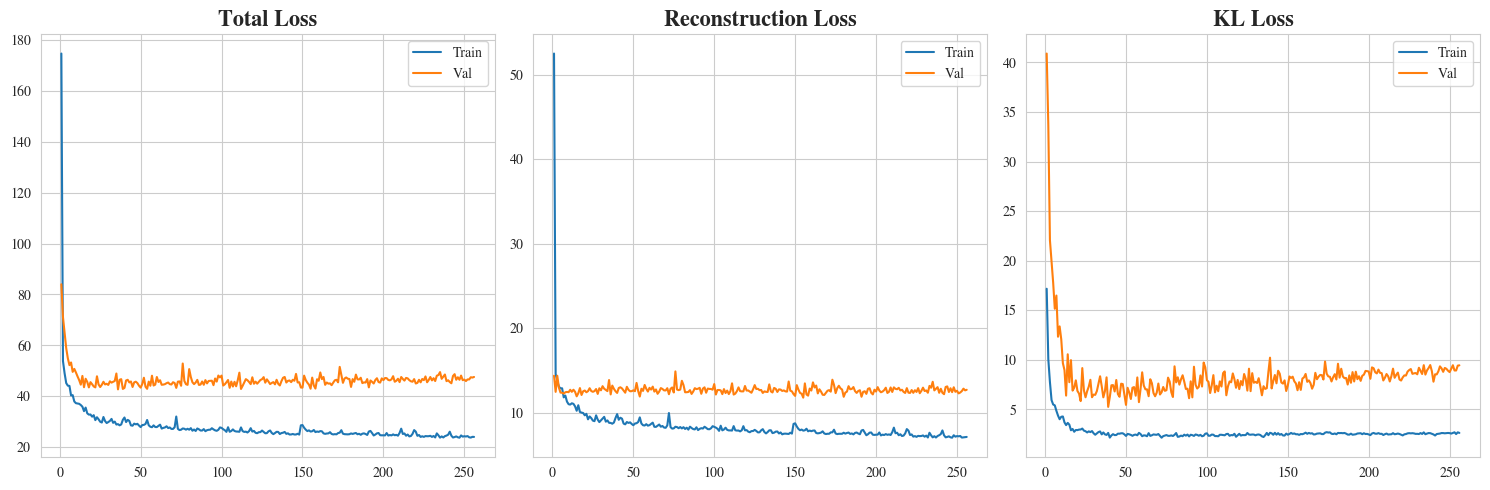

In [11]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved History in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/history.png")


plot_history(history)

# Reconstruction Plotting

In [12]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [13]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 0s 21ms/step


Saved Comparison in '../models/T2023-12-20--15-48-06---E256-B4-VAL20-LD5/assets/'


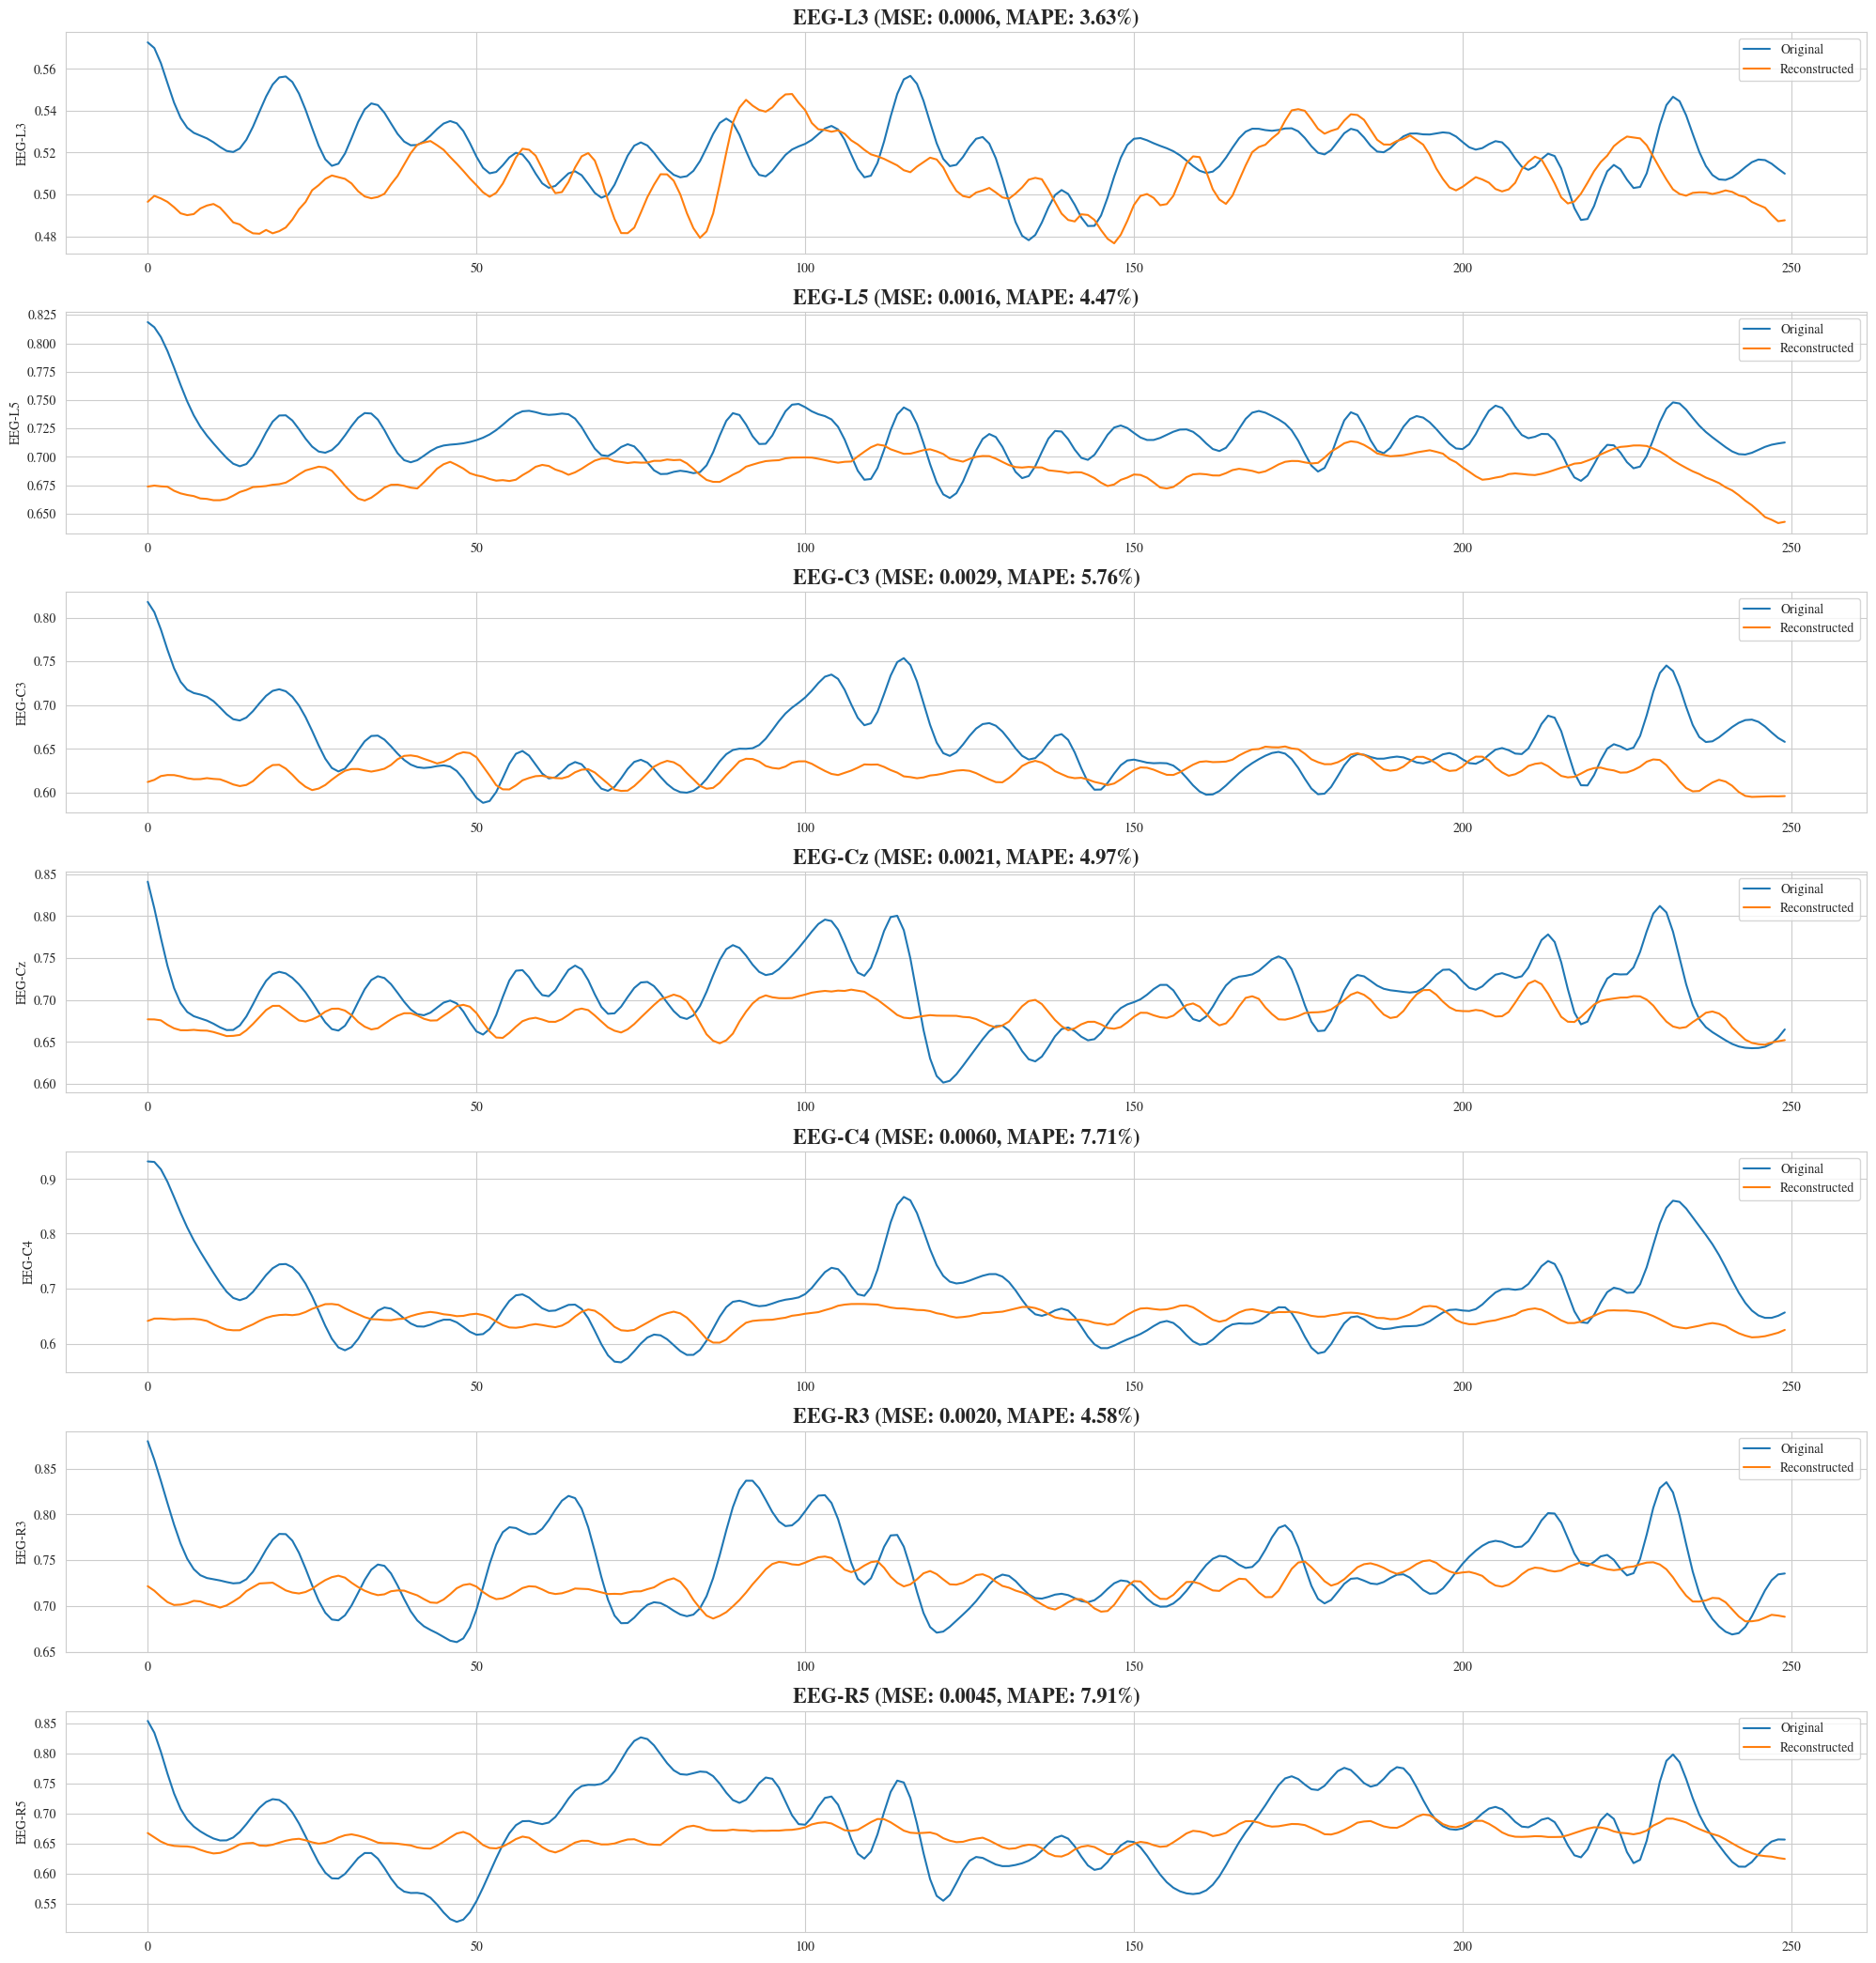

In [14]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    # Compute MSE and MAPE along the rows, for each column
    mse = np.mean(((train_sample[0] - train_sample_reconstructed[0])**2), axis=0)
    mape = np.mean(np.abs((train_sample[0] - train_sample_reconstructed[0]) / train_sample[0]), axis=0) * 100

    # Convert to pd.DataFrame for plotting reasons
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for i, (col, ax) in enumerate(zip(FEATURE_NAMES, axes.flatten())):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(f"{col} (MSE: {mse[i]:.4f}, MAPE: {mape[i]:.2f}%)", fontweight="bold", size=16)
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved Comparison in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/comparison.png")


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [15]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


In [16]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

#plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [17]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)

## Visualize using TSNE

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(perplexity=10)
z_dim_reduced = tsne.fit_transform(z_mean)

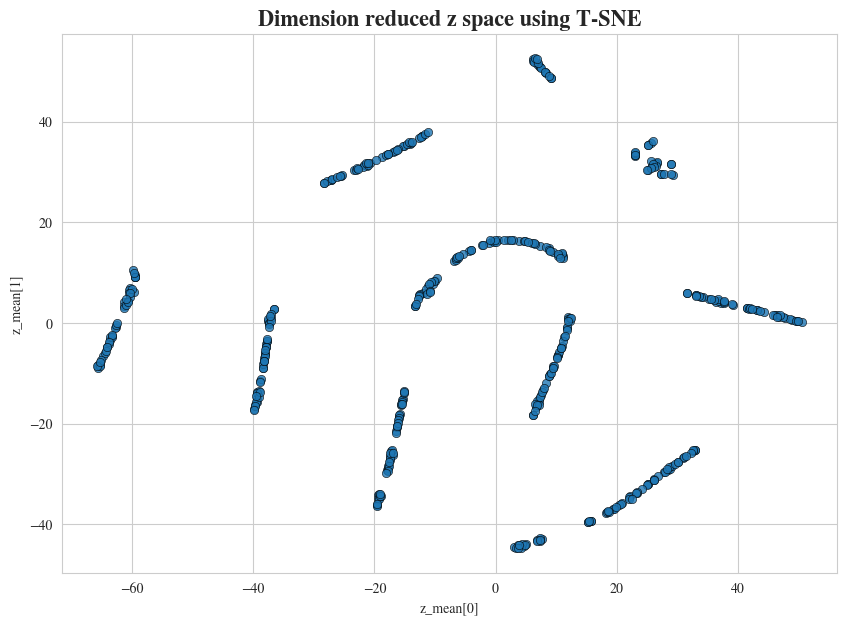

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8)
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

## Visualize using PCA

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [22]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [23]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 1.00


array([0.99740682, 0.0013873 ])

In [24]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[ 1.28169126,  0.04361542],
       [ 0.03972019, -0.02317023],
       [-1.40085184,  0.02589526]])

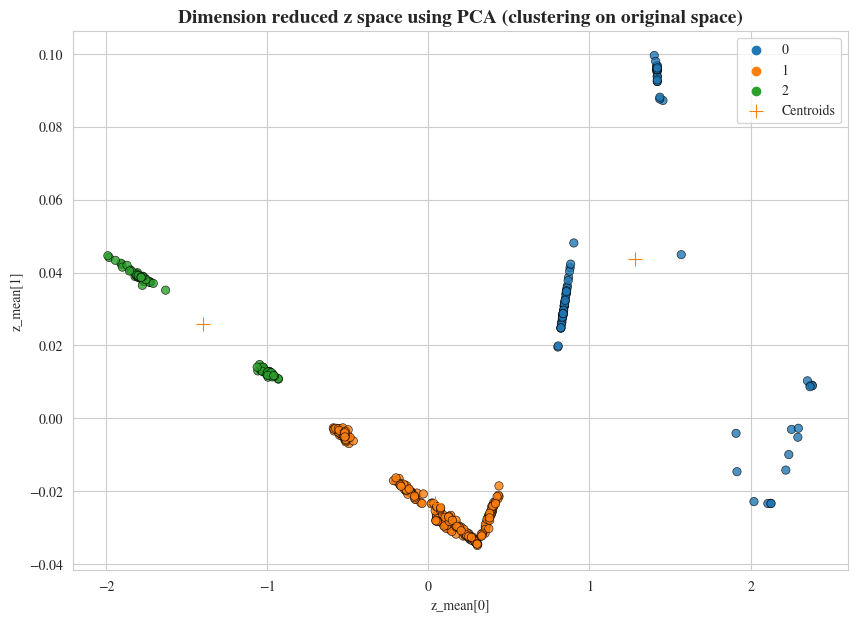

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA (clustering on original space)", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=labels, palette="tab10")
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [26]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [27]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

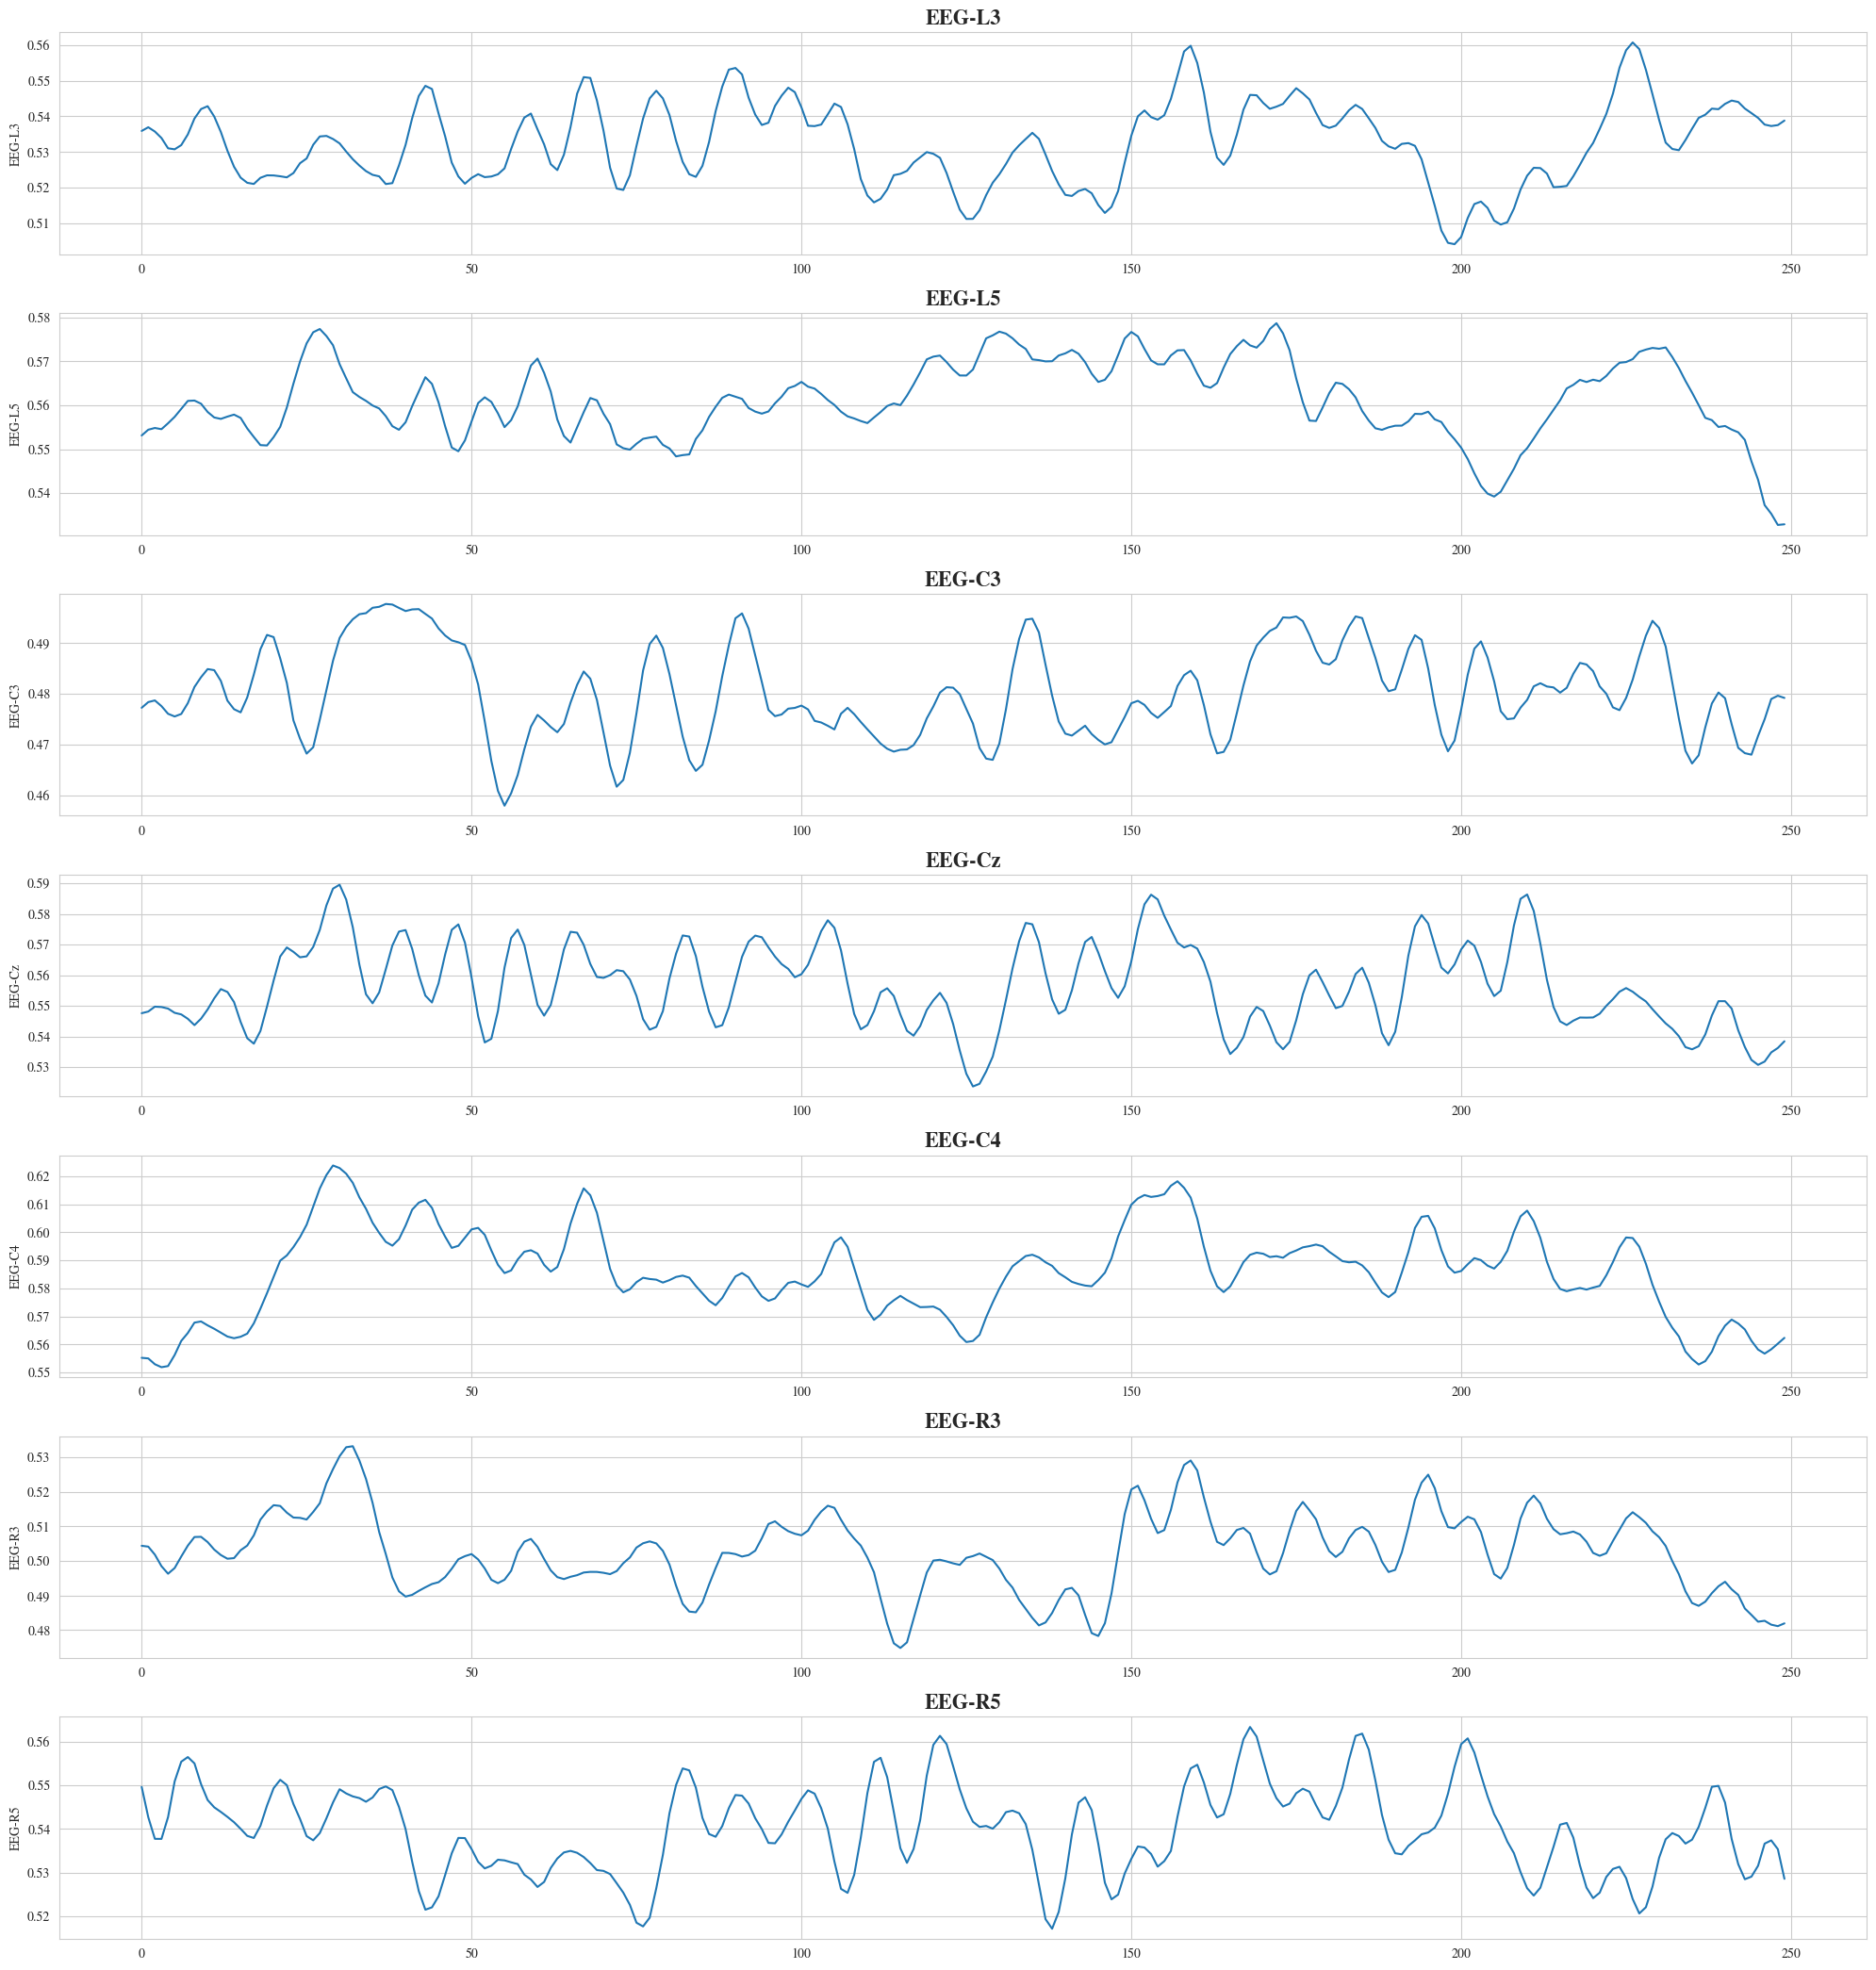

In [28]:
plot_all_time_series(sample_z_mean_reconstructed[0])

## Visualize Clusters

In [29]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [30]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

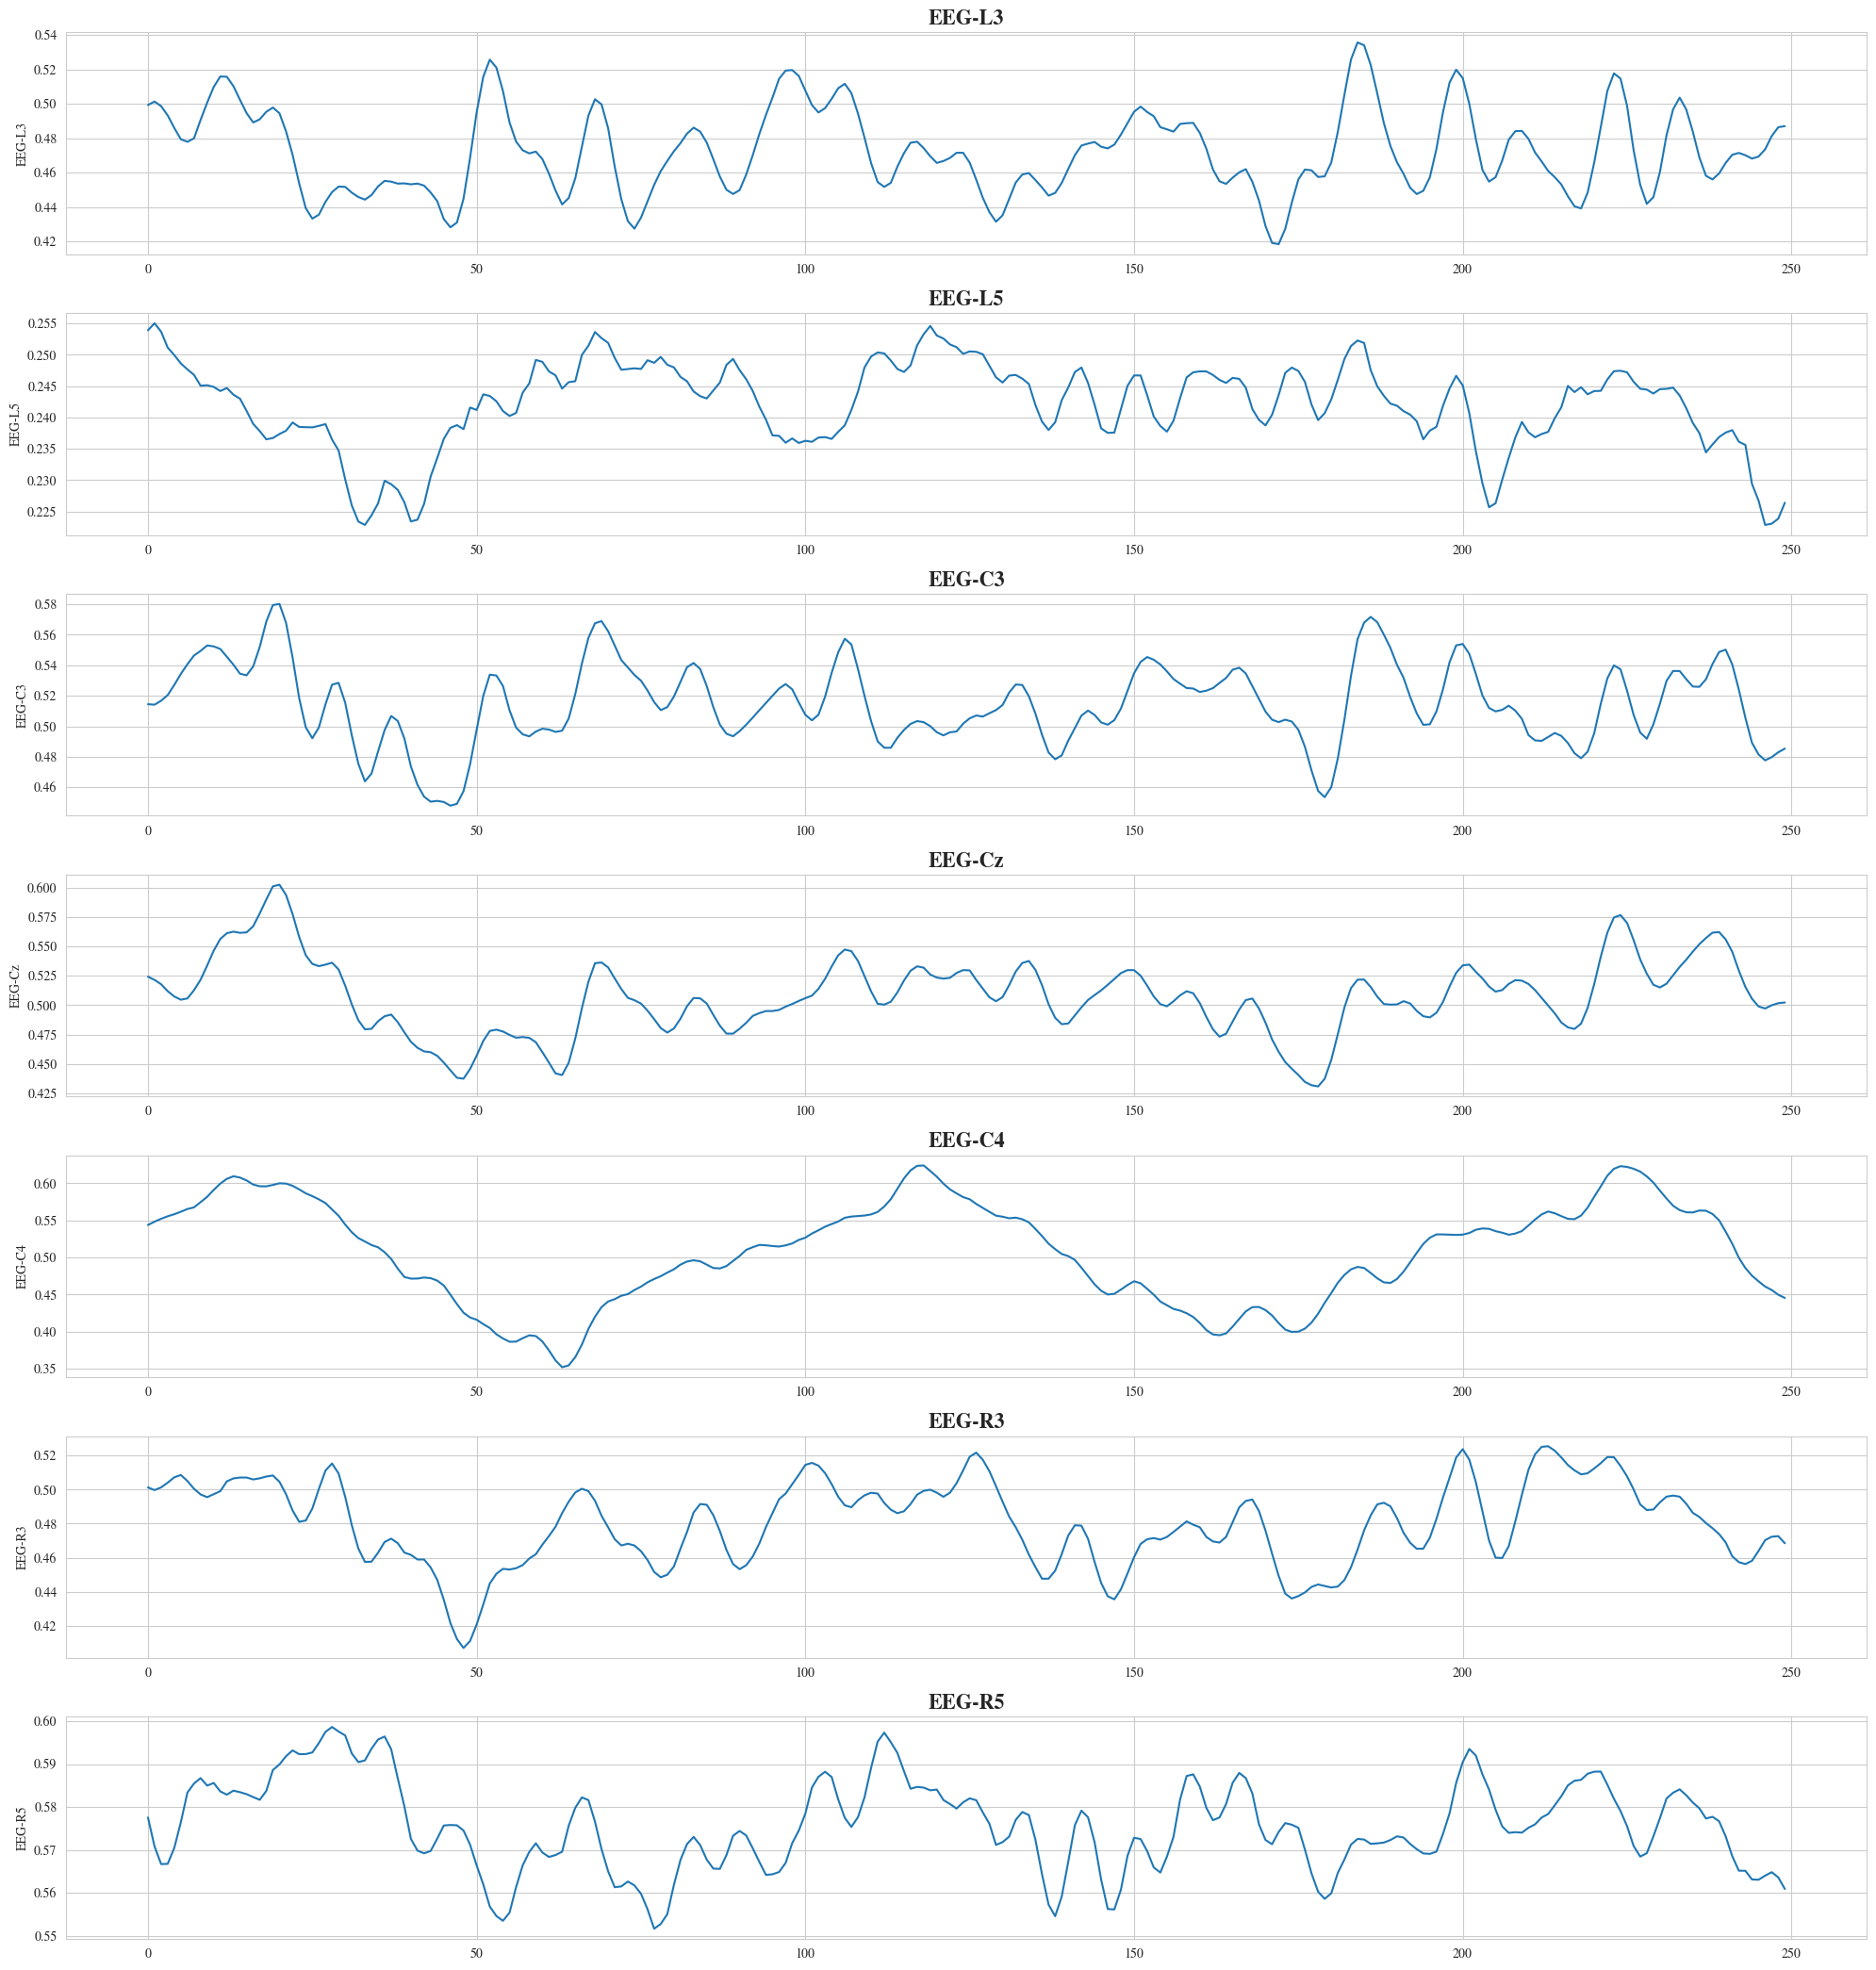

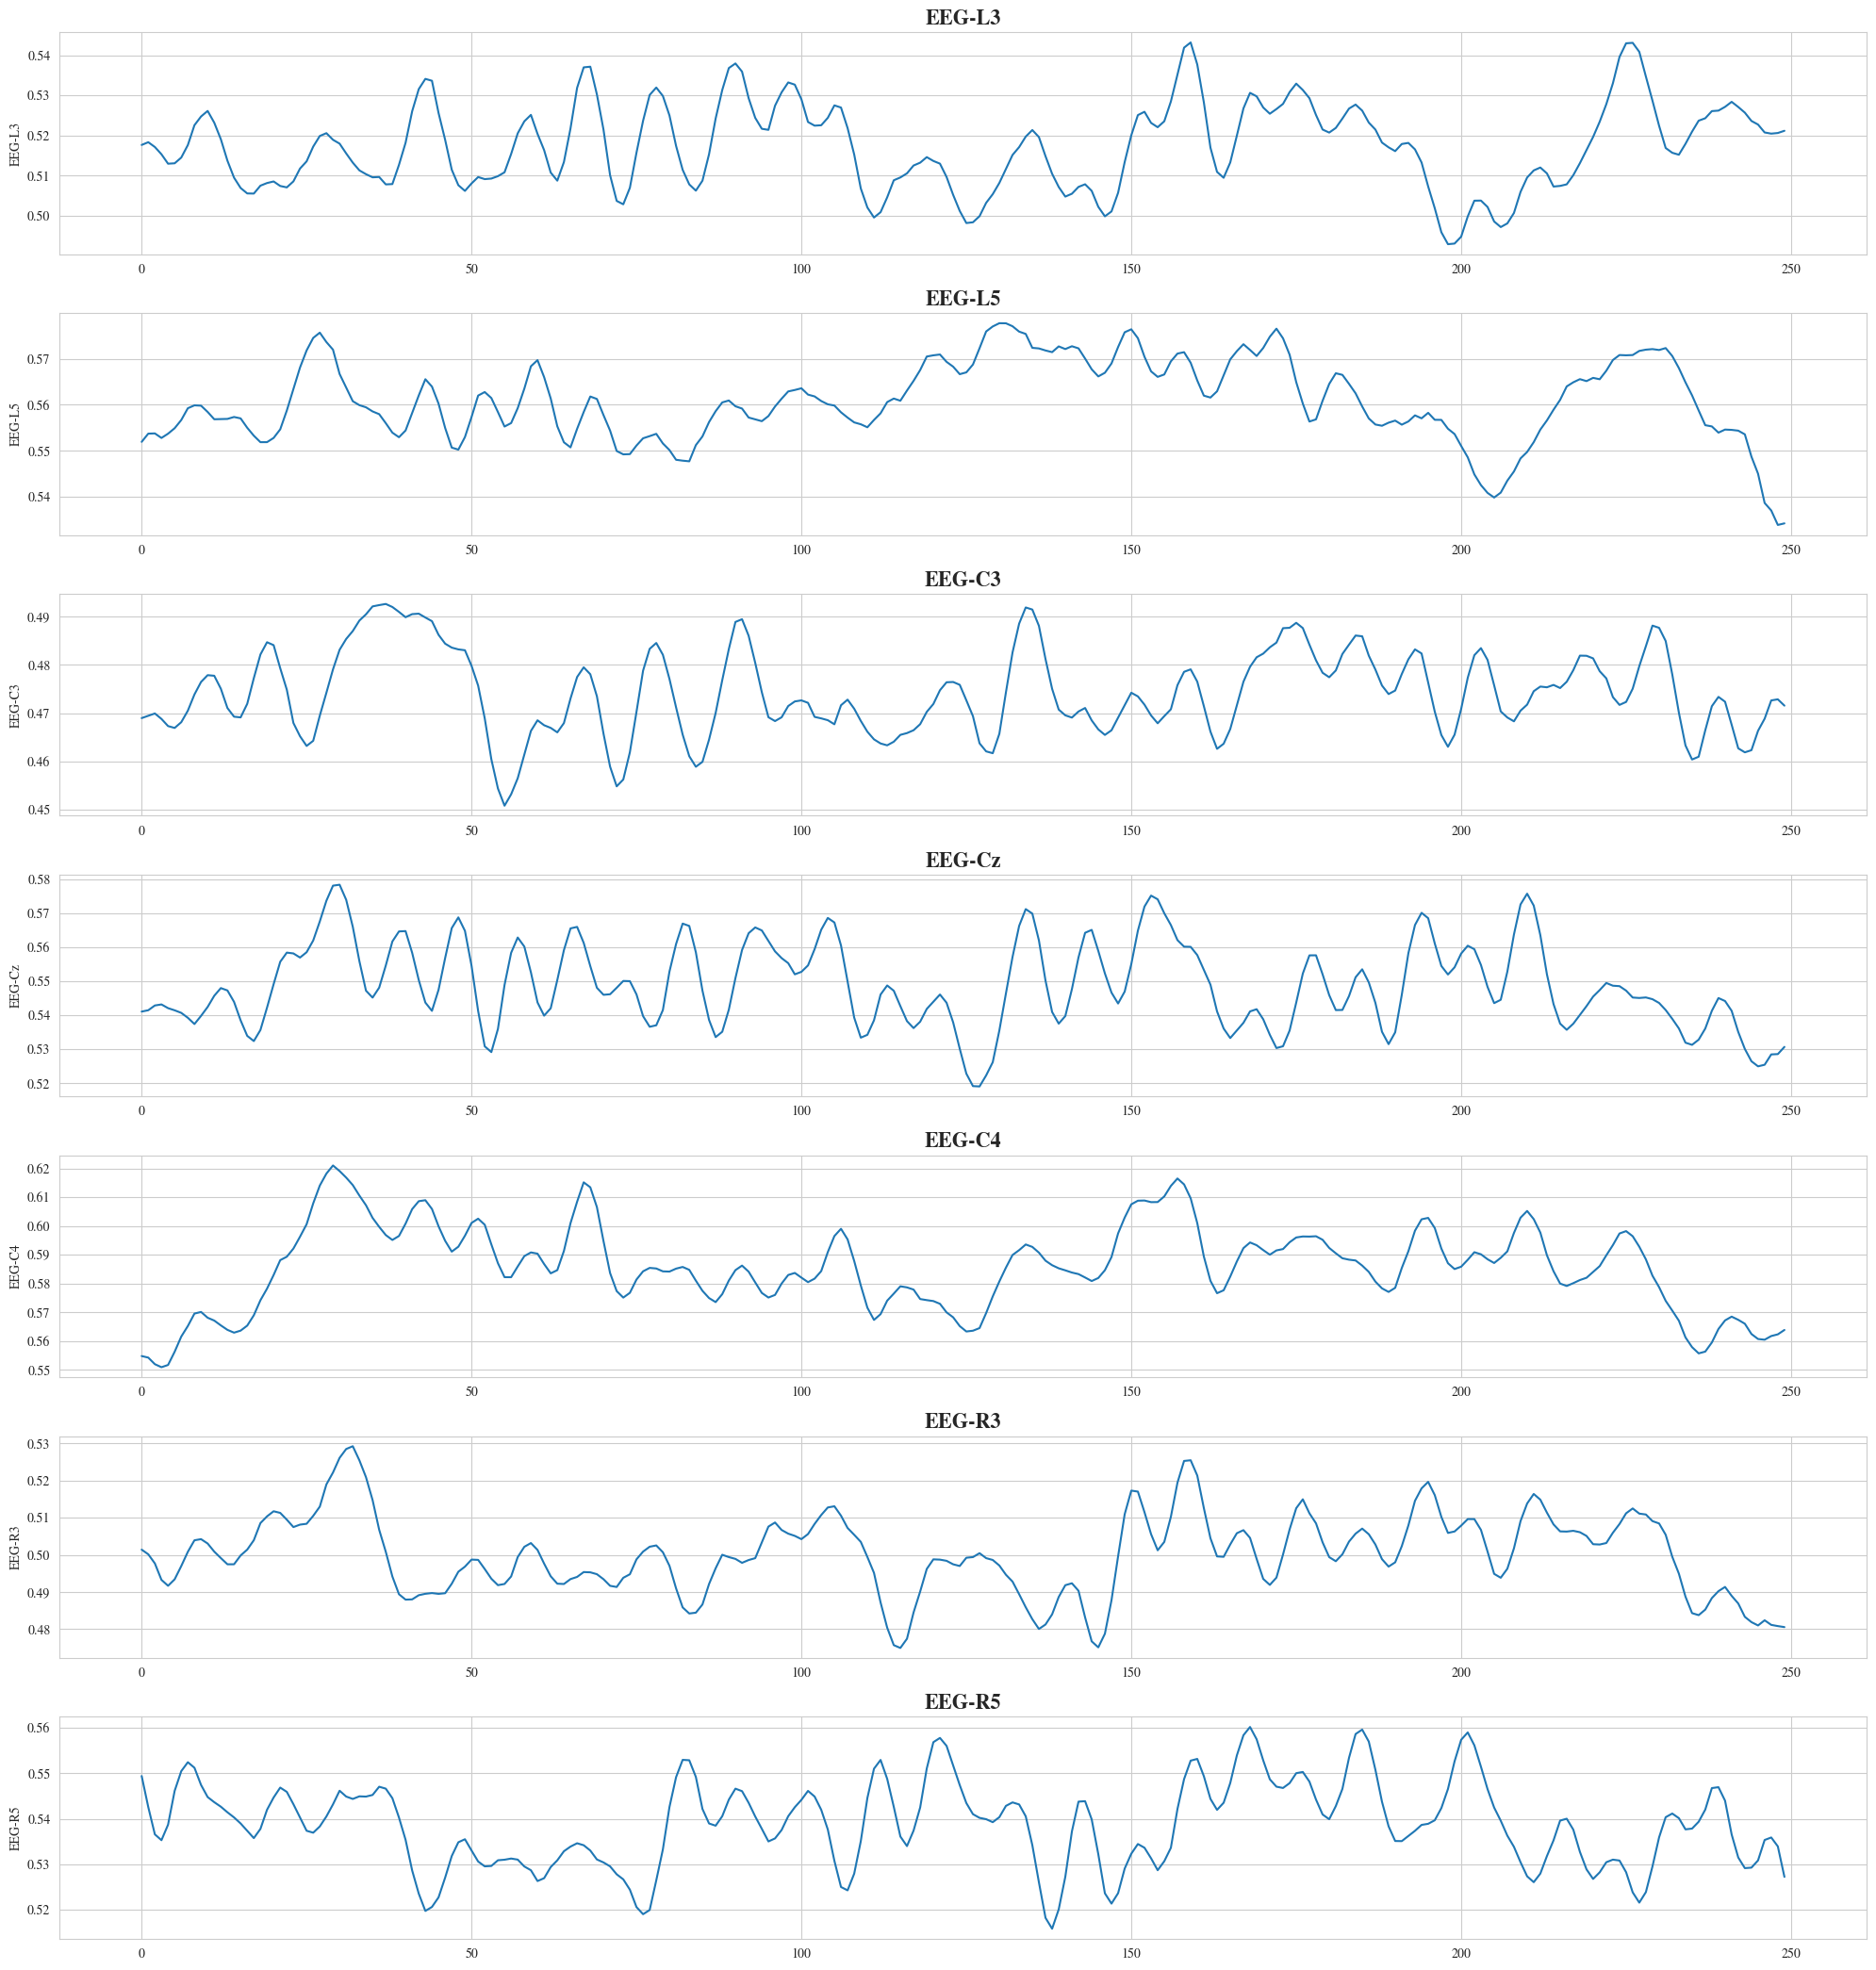

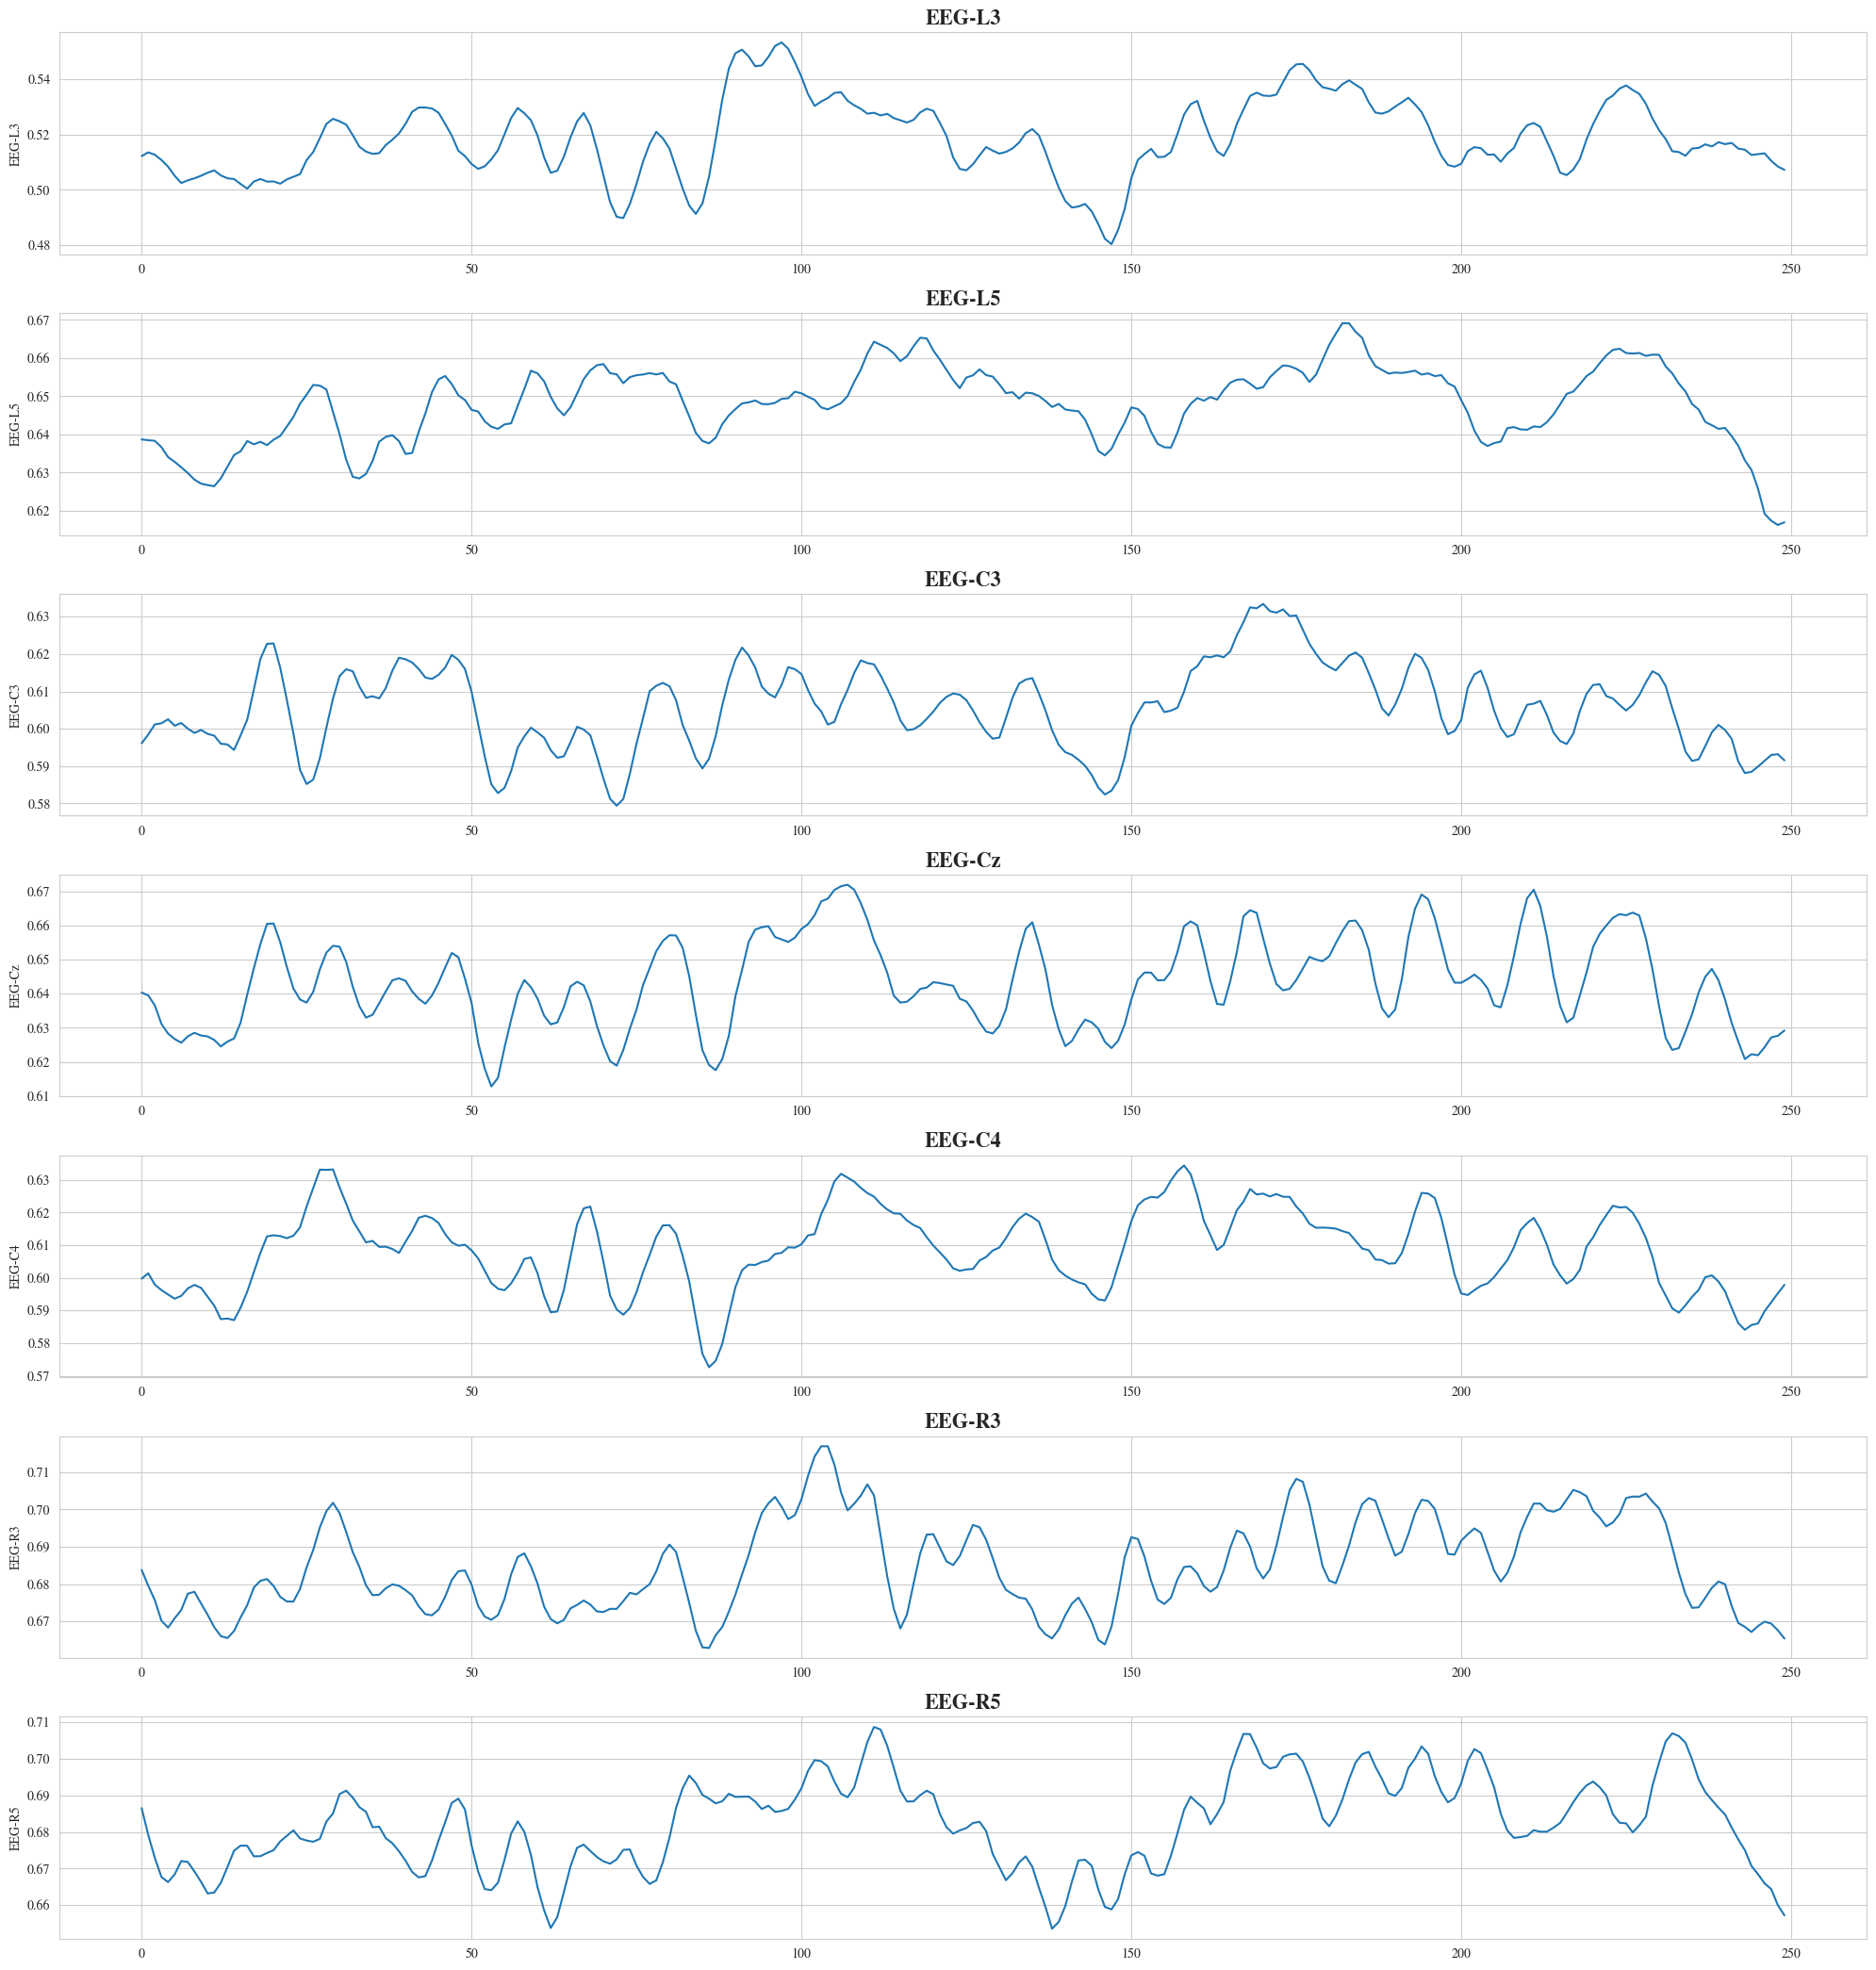

In [31]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])